## TP 9

Le but de ce TP est de réaliser l'extraction de features d'images afin d'en réaliser une segmentation (apprentissage NON supervisé) puis de comparer les résultats de cette segmentation avec les classes d'origine (nous réaliserons une réelle classification dans un TP ultérieur). L'idée est plutôt d'informer la faisabilité d'un moteur de classification d'images tout en étudiant au passage la pertinence du choix du référentiel de classes.

Mettre à jour au fur et à mesure la cellule suivante des imports.

In [1]:
from glob import glob
import os
from typing import Sequence

from dotenv import load_dotenv
from matplotlib.image import imread
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import decomposition, preprocessing, manifold, metrics, cluster
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array

## Préparation du dataset

Créer un fichier .env et y spécifier le chemin du dossier contenant les images du fichier .env. Charger le .env et récupérer ce chemin.

In [2]:
load_dotenv()
IMG_FOLDER = os.getenv("IMG_FOLDER")

Initialiser une constante contenant la liste référentielle des labels possibles.

In [3]:
LABELS_LIST = ["cloudy", "rain", "shine", "sunrise"]

En observation la convention de nommage des fichiers images, écrire une fonction (efficace) permettant de déterminer le label d'une photo à partir du nom du fichier.

In [4]:
def get_image_label(
    img_filename: str,
    possible_labels: Sequence[str] | None = None,
    label_not_found: str = "unknown",
) -> str:
    if possible_labels is None:
        possible_labels = LABELS_LIST
    for label in possible_labels:
        if label in img_filename:
            return label
    return label_not_found

Ecrire une fonction créant un dataframe pandas contenant le chemin vers l'image et le label. Construire le dataframe associé à notre jeu de données.

In [5]:
def create_df_from_img(path: str) -> pd.DataFrame:
    df_out = pd.DataFrame(data={"image_path": glob(f"{path}*/*.jp*")})  # jpg/jpeg files
    df_out["label_name"] = df_out["image_path"].apply(get_image_label)
    return df_out

In [6]:
img_df = create_df_from_img(IMG_FOLDER)

In [7]:
img_df

,image_path,label_name
0,../../data\weather-dataset\cloudy1.jpg,cloudy
1,../../data\weather-dataset\cloudy10.jpg,cloudy
2,../../data\weather-dataset\cloudy100.jpg,cloudy
3,../../data\weather-dataset\cloudy101.jpg,cloudy
4,../../data\weather-dataset\cloudy102.jpg,cloudy
...,...,...
1120,../../data\weather-dataset\sunrise95.jpg,sunrise
1121,../../data\weather-dataset\sunrise96.jpg,sunrise
1122,../../data\weather-dataset\sunrise97.jpg,sunrise
1123,../../data\weather-dataset\sunrise98.jpg,sunrise


Encoder le label à l'aide du LabelEncoder de scikit-learn.

In [8]:
label_encoder = preprocessing.LabelEncoder()
img_df["label"] = label_encoder.fit_transform(img_df["label_name"])

In [9]:
display(img_df)

,image_path,label_name,label
0,../../data\weather-dataset\cloudy1.jpg,cloudy,0
1,../../data\weather-dataset\cloudy10.jpg,cloudy,0
2,../../data\weather-dataset\cloudy100.jpg,cloudy,0
3,../../data\weather-dataset\cloudy101.jpg,cloudy,0
4,../../data\weather-dataset\cloudy102.jpg,cloudy,0
...,...,...,...
1120,../../data\weather-dataset\sunrise95.jpg,sunrise,3
1121,../../data\weather-dataset\sunrise96.jpg,sunrise,3
1122,../../data\weather-dataset\sunrise97.jpg,sunrise,3
1123,../../data\weather-dataset\sunrise98.jpg,sunrise,3


Vérifier le nombre d'images dans chaque classe.

In [10]:
img_df.groupby("label").count()

,image_path,label_name
label,,
0,300,300
1,215,215
2,253,253
3,357,357


La cellule suivante (utilisant matplotlib) permet de visualiser 3 images côte à côte représentatives de chaque label. L'exécuter pour vérifier la cohérence de la sortie.

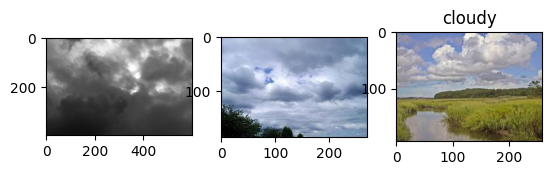

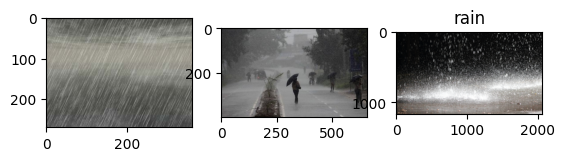

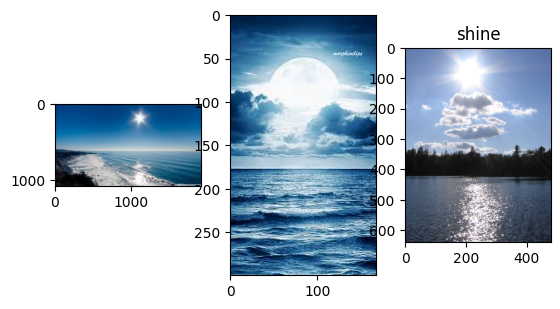

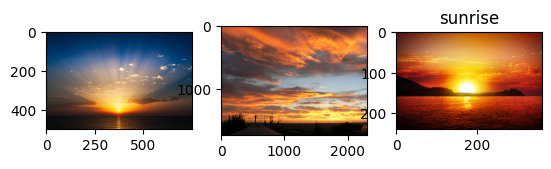

In [11]:
for label_name in LABELS_LIST:
    mask = img_df["label_name"]==label_name
    image_path_list = img_df[mask].reset_index().loc[0:2, "image_path"]
    for i in range(3):
        image = imread(image_path_list[i])  
        plt.subplot(131 + i)
        plt.imshow(image)
    plt.title(label_name)
    plt.show() 

## Feature extraction

### Création du modèle pré-entraîné

Charger le modèle VGG16 de tensorflow.keras.applications.vgg16. Pour plus de renseignements sur l'architecture de VGG16, il est possible de consulter par exemple la ressource suivante : https://datacorner.fr/vgg-transfer-learning/.

In [12]:
base_model = VGG16()

Afficher les 5 dernières couches du modèle à l'aide de .layers.

In [13]:
base_model.layers[-5:]

L'ouput n'est pas très lisible. Afficher un résumé de l'architecture du modèle avec .summary().

In [14]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

Construire un nouveau modèle à partir du modèle VGG16 amputé de toutes ses n-1 dernières couches Dense, où n désigne le nombre de couches Dense successives en aval du modèle. Pour cela, utiliser instancier un objet de la classe Model du module tensorflow.keras.models, en passant comme arguments du constructeurs :
- inputs: les inputs du modèle VGG16,
- outputs: le résultat de l'appel de .output sur la liste des couches du modèle VGG16 amputé des n-1 dernières couches.

Afficher un résumé de l'architecture du modèle.

In [15]:
model = Model(inputs=base_model.inputs, outputs=base_model.layers[-3].output)
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

## Création des features des images

Préparer une fonction prenant en entrée le chemin vers une image et renvoyant les features extraites grâce au modèle, en appliquant les étapes successives suivantes :
- chargement de l'image à l'aide de la fonction load_img de tensorflow.keras.preprocessing.image, en fixant une taille de 224x224,
- conversion en array à l'aide de la fonction img_to_array de tensorflow.keras.preprocessing.image également,
- ajout d'un axe à partir de l'axe 0 à l'aide de la fonction expand_dims de numpy (pour en visualiser l'utilité, essayer de commenter la ligne dans la fonction et constater l'erreur lors de l'appel sur une image),
- prétraitement pour normaliser le tableau représentant l'image avec la fonction standard preprocess_input de tensorflow.keras.applications.vgg16 (sans se poser plus de questions : les modèles keras viennent généralement avec leur fonction de prétraitement des images adaptées de manière spécifique au modèle en question),
- prédiction des features à partir de la méthode predict du modèle.

In [16]:
def extract_features(image_path: str, model: Model) -> np.array:
    img_array = img_to_array(load_img(image_path, target_size=(224, 224)))
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return model.predict(img_array, verbose=False)[0]

<font color="green"> A noter que nous avons fait le choix de réaliser la préparation des données et l'extraction de features dans la même fonction. Nous aurions pu séparer ce traitement en 2 étapes, d'autant que c'est ce que nous ferons dans la suite. </font>

Appliquer cette fonction à l'ensemble du dataset ligne par ligne. Convertir le résultat en array numpy de taille nombre d'images x nombre de features à l'aide de la fonction np.stack (appliquer auparavant .values sur les features extraites).

In [17]:
X_features = np.stack(
    img_df["image_path"].apply(lambda image_path: extract_features(image_path, model))
)

Afficher la taille de ce tableau.

In [18]:
X_features.shape

(1125, 4096)

## Réduction de dimension

### Réduction de dimension via ACP pour l'extraction même de features

Appliquer une simple ACP pour réduire la dimension de l'image. Choisir par exemple de conserver un nombre de composantes tel que la quantité de variance expliquée soit supérieure à 99%. Vérifier la taille du tableau de features en sortie de l'ACP.

In [19]:
pca = decomposition.PCA(n_components=0.99)
reduced_X_features = pca.fit_transform(X_features)

In [20]:
reduced_X_features.shape

(1125, 797)

### Réduction de dimension T-SNE pour la visualisation

Projeter les features en dimension 2 pour la visualisation, grâce à un TSNE. Consulter la documentation de ce modèle.

In [21]:
tsne = manifold.TSNE(n_components=2, perplexity=30, n_iter=2000, init="random", random_state=6)
X_tsne = tsne.fit_transform(reduced_X_features)

c:\Users\bspeziale\AppData\Local\pypoetry\Cache\virtualenvs\test-yOZBwoax-py3.11\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\bspeziale\AppData\Local\pypoetry\Cache\virtualenvs\test-yOZBwoax-py3.11\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


Reformer un dataframe contenant l'ensemble des features post-TSNE ainsi qu'une dernière colonne contenant le label. En afficher un échantillon aléatoire de taille 10.

In [22]:
tsne_df = pd.DataFrame(data=X_tsne, columns=["tsne_1", "tsne_2"])
tsne_df["class"] = img_df["label_name"]
tsne_df.sample(10)

,tsne_1,tsne_2,class
874,-3.960520,-41.529434,sunrise
593,-41.402405,-0.224433,shine
111,2.784137,11.065734,cloudy
141,-3.892001,-11.867240,cloudy
106,-1.693689,-2.560155,cloudy
472,2.987611,56.370010,rain
406,3.605203,23.223207,rain
629,26.396334,29.752487,shine
312,-5.690007,31.045338,rain
784,17.988903,-17.267847,sunrise


Voici une fonction (nous la réutiliserons plus tard) permettant d'afficher le nuage de points des individus sur l'espace de projection de dimension (cette fois en combinant plt avec un scatterplot seaborn, pour varier les plaisirs).

Même si nous n'utiliserons pas les vraies classes pour segmenter ce nuage de points, nous affichons avec des couleurs différentes les points ayant des labels différents à fin purement informative. Le nom de la colonne du dataframe à partir de laquelle colorer les points est un argument d'entrée de notre fonction d'affichage.

In [23]:
def create_tsne_viz(tsne_df: pd.DataFrame, hue_col: str) -> None:
    plt.figure(figsize=(10,5))
    sns.scatterplot(
        tsne_df,
        x="tsne_1",
        y="tsne_2",
        hue=hue_col,
    )
    plt.title(f"TSNE et visualisation - {hue_col}.")
    plt.xlabel("Première composante")
    plt.ylabel("Seconde composante")
    plt.show()

Appeler cette fonction sur notre jeu de données :

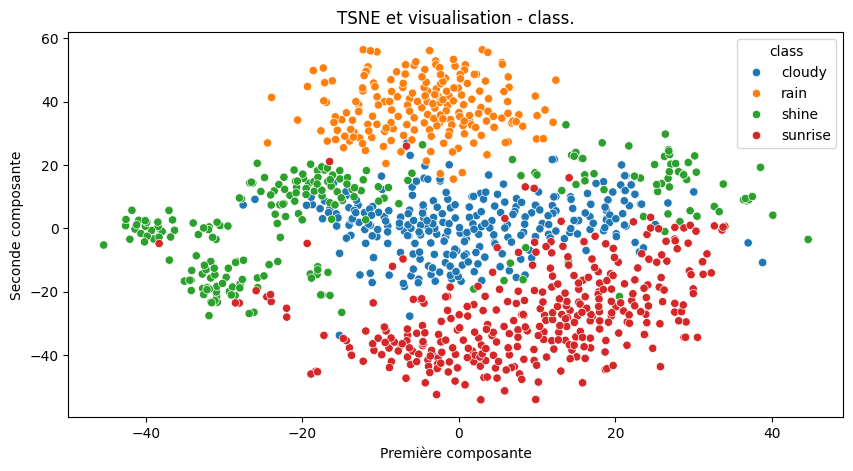

In [24]:
create_tsne_viz(tsne_df=tsne_df, hue_col="class")

Quelques interprétations :
- L'analyse graphique donne des indices visuels quand à la faisabilité de la séparation automatique des images selon leurs vraies classes -> se faire une idée sur la question. Cela permet d'estimer la faisabilité de réaliser ultérieurement une classification supervisée pour déterminer automatiquement les classes des images.
- Cette étape est plutôt rapide à réaliser, notamment parce qu'elle ne demande l'entraînement de task nets. Une conclusion négative sur la faisabilité peut permettre d'éviter de réaliser des traitements plus lourds. Cela permet également de discuter du caractère "naturel" du découpage en labels déjà effectué (il serait peut-être possible de découper ce même dataset en 4 groupes plus isolés, sur la base de l'extraction de features effectuées).
- On peut image que cette démarche en plusieurs étapes s'inscrive dans la démarche agile d'un projet data.

### Clustering (à partir de l'output du t-SNE)

Il s'agit ici de conforter simplement, par une mesure de l'ARI, l'analyse graphique précédente qui semble montrer la faisabilité relative d'une classification supervisée, avec des difficultés à prévoir pour segmenter les images "shine". Cette mesure de l'ARI nécessite de créer des clusters théoriques.
Pour réaliser une mesure de ce que nous voyons graphiquement, il faut partir des données en sorties du t-SNE. Pour toute autre application (classification ou segmentation réelle des images), il faudra repartir des features extraites par l'ensemble des étapes dédiées à cela, c'est-à-dire en sortie de l'ACP mais en amont du t-SNE.
Le score ARI est lié aux labels des données ; aussi rien ne garantit que la "meilleure" solution de feature engineering, si tant est qu'elle existe, sera celle qui génère le meilleur ARI.


Nous faisons ici le choix de mettre en oeuvre l'algorithme K-means. Mettre en oeuvre un tel modèle en fixant un nombre de clusters égal au nombre de classes anticipé (4).

In [25]:
kmeans = cluster.KMeans(n_clusters=4, n_init="auto", random_state=9)
kmeans.fit(reduced_X_features)

KMeans(n_clusters=4, n_init='auto', random_state=9)

Ajouter au dataframe des données extraites pour le t-SNE une colonne contenant le numéro du cluster affecté par K-means. En afficher un échantillon aléatoire de taille 10.

In [26]:
tsne_df["cluster_kmeans"] = kmeans.labels_

In [27]:
tsne_df.sample(10)

,tsne_1,tsne_2,class,cluster_kmeans
952,6.733501,-43.933876,sunrise,1
811,15.320868,-19.206226,sunrise,1
501,1.986195,48.590122,rain,3
765,-38.490067,1.985931,shine,0
94,-2.408717,15.585340,cloudy,2
661,15.841504,22.041094,shine,2
347,8.162598,32.216217,rain,2
843,33.646057,-0.522676,sunrise,2
1043,8.710720,-32.354603,sunrise,1
921,10.870749,-32.677208,sunrise,1


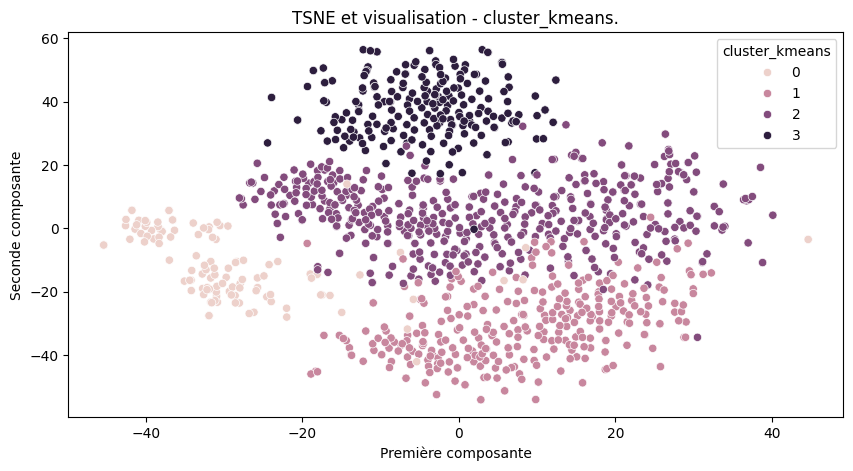

In [28]:
create_tsne_viz(tsne_df=tsne_df, hue_col="cluster_kmeans")

Effectuer à l'oeil une correspondance (bijective) entre les classes et les clusters (il est bien entendu possible d'automatiser la recherche d'une telle correspondance maximisant la métrique de similarité, mais ici, cela peut être réalisé visuellement).

In [29]:
cluster_class_map = {
    0: "shine",
    1: "sunrise",
    2: "cloudy",
    3: "rain",
}

Dénombrer le nombre d'images shine affectées au cluster cloudy.

In [30]:
mask = (tsne_df["class"] == "shine") & (tsne_df["cluster_kmeans"]==2)
mask.sum()

147

Afficher une image shine considérée comme cloudy par le clustering. Essayer d'interpréter d'où peut venir la confusion (si possible).

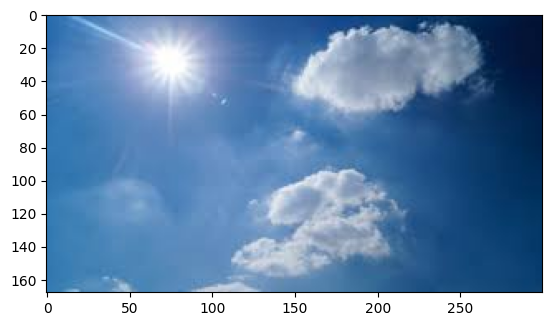

In [31]:
filename = img_df[mask].reset_index().loc[2, "image_path"]
img = imread(filename)
plt.imshow(img)
plt.show()

Selon les images obtenues, la confusion peut venir de la présence de neige interprétée comme des nuages, la présence d'un ciel nuageux sans pluie avec du soleil, la présence d'un autre élément remarquable mais non indicateur de la classe (par exemple l'océan), la présence de features "non robustes" telles qu'une colorimétrie très particulière de l'image... Il est aussi possible de tomber sur une image pour laquelle la cause de la confusion n'est pas apparente à l'oeil humain !

Il est désormais temps d'avoir une analyse un peu plus globale des éléments cohérents et de la confusion.

### Analyse par classes

A l'aide de la fonction confusion_matrix du module metrics de scikit-learn, afficher la matrice de confusion brute de notre problème. Veiller à bien réaligner les classes et les clusters. Une fois la matrice brute obtenue, appeler la fonction de la cellule suivante pour améliorer le visuel.

In [32]:
cluster_labels = list(map(cluster_class_map.get, tsne_df["cluster_kmeans"]))
confusion_matrix = metrics.confusion_matrix(
    y_true=tsne_df["class"],
    y_pred = cluster_labels,
    labels=LABELS_LIST,
)
print(confusion_matrix)

[[284   3   2  11]
 [  2 213   0   0]
 [147   3 101   2]
 [ 48   0  12 297]]


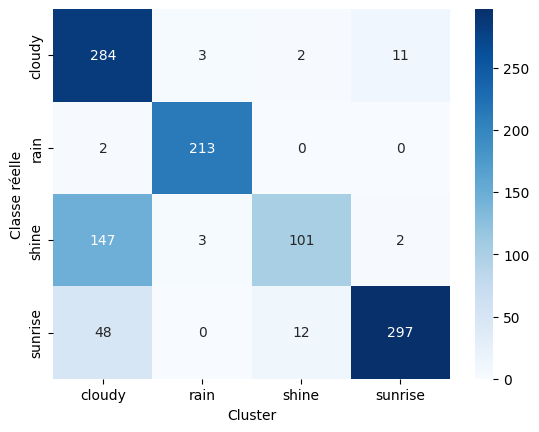

In [33]:
sns.heatmap(
    confusion_matrix,
    annot=True,
    fmt="g",
    cmap="Blues",
    xticklabels=LABELS_LIST,
    yticklabels=LABELS_LIST,
)
plt.xlabel("Cluster")
plt.ylabel("Classe réelle")
plt.show()

Générer également un "rapport de classification" (toujours à partir du module metrics de scikit-learn).

In [34]:
print(metrics.classification_report(tsne_df["class"], cluster_labels))

              precision    recall  f1-score   support

      cloudy       0.59      0.95      0.73       300
        rain       0.97      0.99      0.98       215
       shine       0.88      0.40      0.55       253
     sunrise       0.96      0.83      0.89       357

    accuracy                           0.80      1125
   macro avg       0.85      0.79      0.79      1125
weighted avg       0.84      0.80      0.79      1125



Pour terminer, calculer une mesure de similarité globale telle que le ARI score. Une fonction permettant de le calculer directement est (bien entendu) disponible dans scikit-learn. A votre avis, dans quel module ? Rechercher sur Internet pour savoir quelle est la fonction exacte à utiliser.

In [35]:
metrics.adjusted_rand_score(
    tsne_df["class"],
    cluster_labels,
)

0.5737816281603655

Cette fonction est-elle symétrique ? (Peut-on inverser valeurs réelles et prédites ?)

In [36]:
metrics.adjusted_rand_score(
    cluster_labels,
    tsne_df["class"],
)

0.5737816281603655

Nous allons désormais mettre en oeuvre une segmentation des images. <br>
Nous réutiliserons certaines variables, et il est possible de repartir de la situation pré ou post-extraction de features.
Vous pouvez sauvegarder (sérialiser) ces variables intermédiaires si vous le souhaitez (par exemple au format pickle).

## TP 10

In [ ]:
from plot_keras_history import show_history, plot_history
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.utils import to_categorical
import tensorflow as tf

<font color="orange">Au besoin, adapter la fonction de prétraitement précédente pour ne plus y faire l'extraction de caractéristiques.</font>

In [ ]:
def preprocess_image(image_path: str) -> np.array:
    img_array = img_to_array(load_img(image_path, target_size=(224, 224)))
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img_array[0]

<font color="orange">Appeler alors cette fonction sur notre dataframe d'images.</font> Ce traitement prendra plusieurs minutes.

In [ ]:
img_df["processed_img"] = img_df["image_path"].apply(preprocess_image)

In [40]:
X = np.stack(img_df["processed_img"])

<font color="orange">Préparer le vecteur y en appelant to_categorical sur la colonne contenant le label (numérique).</font>

In [41]:
y = to_categorical(img_df["label"])

<font color="orange">Séparer le jeu de données en un macro-jeu d'entraînement et un jeu de test. Fixer un random_state pour garantir la reproductibilité des résultats pendant la phase d'élaboration de notre modèle. Stratifier selon la cible.</font>

In [42]:
X_macro_train, X_test, y_macro_train, y_test = train_test_split(
    X, y,
    stratify=y,
    test_size=0.2,
    random_state=1,
)

Remarque : généralement cette étape est effectuée AVANT tout autre traitement afin d'éviter tout data leakage. Pour autant, ici, la fonction de préprocessing s'applique aux images de façon unitaire (le traitement d'un image n'est pas dépendant des autres images), et, étant donné la stratification, toutes les classes du référentiel seront nécessairement représentées dans le jeu d'entraînement et dans celui de test, de sorte que l'encoding de la cible dans le jeu de test ne révèlera pas de surprise de type modalité inconnue.

<font color="orange">Redécouper le jeu d'entraînement en mini-jeu d'entraînement et jeu de validation.</font>

In [43]:
X_train, X_val, y_train, y_val = train_test_split(
    X_macro_train,
    y_macro_train,
    test_size=0.2,
    random_state=15,
)

### Préparation du modèle

<font color="orange">Ecrire une fonction permettant de créer notre modèle VGG16.</font> Pour cela :
- instancier un objet VGG16. A partir de la doc, faire en sorte d'initialiser les points à ceux du modèle pré-entraîné sur le jeu ImageNet. Choisir par exemple de ne pas inclure les 3 premières couches fully-connected, et spécifier dans ce cas une taille d'entrée de 224x224x3
- indiquer que toutes ces couches seront "gelées" (non entraînables). Pour cela, boucler sur l'ensemble des éléments de model.layers et définir l'attribut trainable à False.
- stocker dans une variable model.output, puis ajouter une couche de pooling, une couche dense, une couche de dropout et une dernière couche dense.
- définir le nouveau modèle et le compiler.

<font color="orange">Créer effectivement le modèle, avec un context manager spécifiant le device à utiliser (c'est ici qu'on spécifierait quel GPU utiliser si on en disposer). Dans notre cas, utilisons "/cpu:0"</font>

In [44]:
with tf.device("/cpu:0"):
    base_model = VGG16(include_top=False, input_shape=(224, 224, 3))

    for layer in base_model.layers:
        layer.trainable = False
    
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation="relu")(x)
    x = Dropout(0.5)(x)
    predictions = Dense(4, activation="softmax")(x)
    
    model = Model(inputs=base_model.inputs, outputs=predictions)
    model.compile(loss="categorical_crossentropy", optimizer="rmsprop", metrics=["accuracy"])

<font color="orange">Créer des "callbacks" pour paramétrer un early stopping et sauvegarder le meilleur modèle (checkpoint).</font>

In [45]:
model_save_path = "./model_best.h5"
checkpoint = ModelCheckpoint(
    model_save_path,
    monitor="val_loss",
    verbose=True,
    save_best_only=True,
    mode="min",
)
es = EarlyStopping(
    monitor="val_loss",
    mode="min",
    verbose=True,
    patience=3,
)
callbacks_list = [checkpoint, es]

<font color="orange">A l'intérieur du context manager spécifiant le device à utiliser, lancer l'entraînement du modèle. Prévoir dès maintenant de sauvegarder la sortie dans une variable appelée history (nous l'utiliserons plus tard). Attention à bien préciser le jeu de validation ! </font>

In [46]:
with tf.device("/cpu:0"):
    history = model.fit(
        X_train,
        y_train,
        epochs=5,
        batch_size=64,
        validation_data=(X_val, y_val),
        verbose=True,
        callbacks=callbacks_list,
    )
    

Epoch 1/5
12/12 [==============================] - ETA: 0s - loss: 1.5425 - accuracy: 0.6389
Epoch 1: val_loss improved from inf to 0.28788, saving model to .\model_best.h5


c:\Users\bspeziale\AppData\Local\pypoetry\Cache\virtualenvs\test-yOZBwoax-py3.11\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


12/12 [==============================] - 133s 11s/step - loss: 1.5425 - accuracy: 0.6389 - val_loss: 0.2879 - val_accuracy: 0.9111
Epoch 2/5
12/12 [==============================] - ETA: 0s - loss: 0.4704 - accuracy: 0.8528 
Epoch 2: val_loss improved from 0.28788 to 0.18294, saving model to .\model_best.h5
12/12 [==============================] - 144s 12s/step - loss: 0.4704 - accuracy: 0.8528 - val_loss: 0.1829 - val_accuracy: 0.9167
Epoch 3/5
12/12 [==============================] - ETA: 0s - loss: 0.2639 - accuracy: 0.9139
Epoch 3: val_loss improved from 0.18294 to 0.10250, saving model to .\model_best.h5
12/12 [==============================] - 133s 11s/step - loss: 0.2639 - accuracy: 0.9139 - val_loss: 0.1025 - val_accuracy: 0.9444
Epoch 4/5
12/12 [==============================] - ETA: 0s - loss: 0.2179 - accuracy: 0.9278
Epoch 4: val_loss improved from 0.10250 to 0.09553, saving model to .\model_best.h5
12/12 [==============================] - 132s 11s/step - loss: 0.2179 - acc

<font color="orange">Vérifier le score du dernier epoch sur le jeu d'entraînement et le jeu de validation grâce à la méthode evaluate de notre modèle entraîné.</font>

In [47]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=True)
print("Training Accuracy: {:.4f}".format(accuracy))
print()
loss, accuracy = model.evaluate(X_val, y_val, verbose=True)
print("Validation Accuracy: {:.4f}".format(accuracy))

23/23 [==============================] - 105s 5s/step - loss: 0.0769 - accuracy: 0.9736
Training Accuracy: 0.9736

6/6 [==============================] - 26s 4s/step - loss: 0.1653 - accuracy: 0.9333
Validation Accuracy: 0.9333


<font color="orange">Vérifier le score de l'epoch optimal sur le jeu de validation et le jeu de test.</font>

In [48]:
model.load_weights(model_save_path)

loss, accuracy = model.evaluate(X_val, y_val, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy))

loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy))


Validation Accuracy :  0.9556
Test Accuracy       :  0.9244


<font color="orange">Consulter la doc de plot_keras_history. A partir de celle-ci, visualiser l'évolution de la loss et de l'accuracy au fil des epochs.</font>

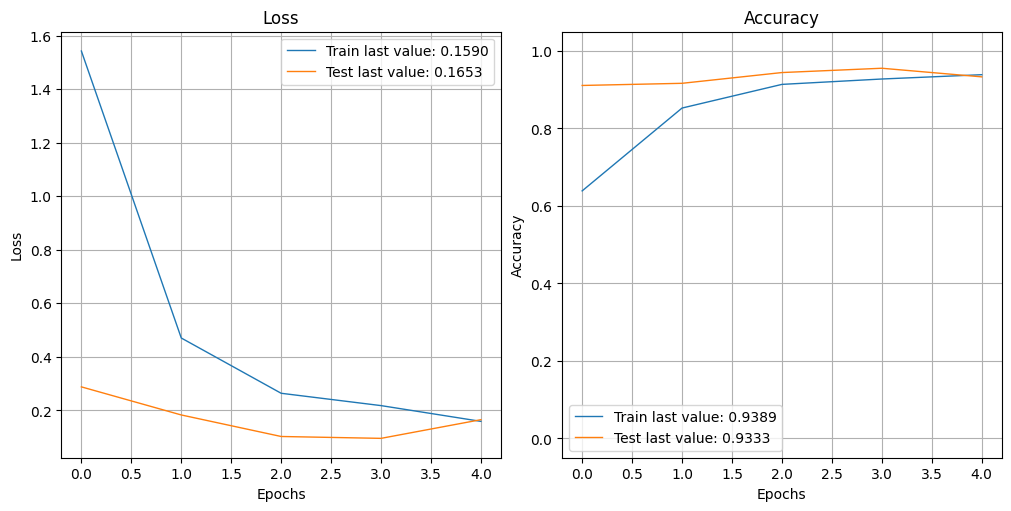

In [51]:
show_history(history)
plot_history(history, path="standard.png")
plt.close()

<font color="orange">Afficher les classes réelles et prédites sur les images du jeu de validation.</font>

In [52]:
y_val_num = np.argmax(y_val, axis=1)
y_val_pred = np.argmax(model.predict(X_val), axis=1)

print(y_val_num)
print(y_val_pred)

6/6 [==============================] - 25s 4s/step
[2 3 3 3 3 3 2 3 3 0 0 2 1 2 2 2 2 2 1 3 1 3 0 1 3 2 0 2 3 2 0 2 2 3 2 0 3
 3 3 0 0 1 3 0 1 2 3 1 2 0 3 3 0 0 1 1 0 2 3 3 3 3 3 3 1 0 3 3 0 3 3 1 2 2
 0 0 3 3 0 2 1 2 0 0 1 3 3 0 3 0 0 3 2 1 3 2 3 2 3 1 3 3 2 2 2 1 0 1 1 1 3
 2 3 1 3 2 3 0 3 1 3 0 3 2 1 2 0 2 3 3 0 0 0 3 0 1 0 2 3 3 2 3 1 1 0 0 1 2
 0 3 0 2 0 1 3 3 0 0 1 1 0 3 2 1 3 0 3 1 2 2 1 1 0 0 0 0 0 2 3 3]
[2 3 3 3 3 3 2 3 3 0 0 0 1 2 2 2 2 2 1 3 1 3 0 1 3 2 0 2 3 2 0 2 0 3 2 0 3
 3 3 0 0 1 3 0 1 2 3 1 2 0 3 3 0 0 1 1 0 0 3 3 3 3 3 3 1 0 3 3 0 3 3 1 2 2
 0 0 3 3 0 2 1 2 0 0 1 3 3 0 3 0 0 3 2 1 3 2 3 0 3 1 3 3 2 2 2 1 0 1 1 1 3
 2 3 1 3 2 3 0 3 1 3 0 3 2 1 2 0 2 3 3 0 0 0 3 0 1 0 2 3 3 2 3 1 1 0 3 1 2
 0 2 0 2 0 1 3 3 0 0 1 1 0 3 2 1 3 0 3 1 2 2 1 1 2 0 0 0 0 0 3 3]


<font color="orange">De manière analogue au TP précédent, afficher la matrice de confusion associée ainsi que le rapport de classification.</font>

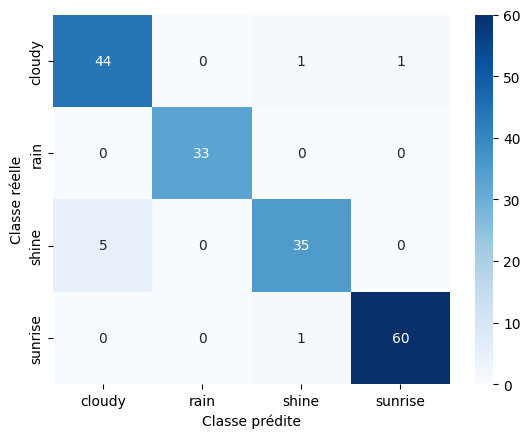

In [53]:
conf_mat = metrics.confusion_matrix(
    y_true=y_val_num,
    y_pred=y_val_pred,
)
sns.heatmap(
    data=conf_mat,
    annot=True,
    cmap="Blues",
    fmt="g",
    xticklabels=LABELS_LIST,
    yticklabels=LABELS_LIST,
)
plt.xlabel("Classe prédite")
plt.ylabel("Classe réelle")
plt.show()

In [54]:
print(metrics.classification_report(y_val_num, y_val_pred))

              precision    recall  f1-score   support

           0       0.90      0.96      0.93        46
           1       1.00      1.00      1.00        33
           2       0.95      0.88      0.91        40
           3       0.98      0.98      0.98        61

    accuracy                           0.96       180
   macro avg       0.96      0.95      0.95       180
weighted avg       0.96      0.96      0.96       180



<font color="orange">Essayer éventuellement de visualiser les prédictions sur les images de test. <br> Il serait en particulier intéressant de voir la prédiction du modèle sur des images présentant des écueils soulevés dans le TP précédent (par exemple des images avec de la neige) qui n'auraient pas été utilisées dans le jeu d'entraînement, s'il y en a.</font>

In [ ]:
def predict_(paths):
    import os
    img_df = pd.DataFrame(
        {
            "image_path": [
                os.path.join(os.getcwd(), path)
                for path in paths
            ]
        }
    )
    X = np.stack(img_df["image_path"].apply(preprocess_image))
    y_class_pred = np.argmax(model.predict(X), axis=1)
    y_class_pred = np.array([LABELS_LIST[i] for i in y_class_pred])
    return y_class_pred


In [78]:
predict_([
    "../../data/test_image_rain.jpg",  # expected: rain
    "../../data/test_image_sunrise.jpg",  # expected: sunrise
])

1/1 [==============================] - 0s 232ms/step


array(['rain', 'sunrise'], dtype='<U7')

### Bonus : data augmentation (intégrée au modèle)

Une ressource utile est celle de tensorflow sur la data augmentation, située à l'adresse suivante : https://www.tensorflow.org/tutorials/images/data_augmentation

Grâce au tutorial (première méthode), créer une data augmentation contenant RandomFlip, RandomRotation et RandomZoom.

In [ ]:
# Votre code ici

<font color="orange">Reprendre l'ensemble des questions précédentes et comparer les deux modèles.</font>

In [ ]:
# Votre code ici